In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import pandas as pd
import graphviz as gr

%matplotlib inline
import seaborn as sns
from scipy import stats
style.use("fivethirtyeight")
from scipy.stats import ttest_ind

In [2]:
! pip install causalinference
from causalinference import CausalModel

In [3]:
#load dataset
df = pd.read_stata('school_intervention_panel_final.dta', convert_categoricals=False)
#useful sub datasets 
follow_up_1_df = df[df['round'] == 0]
follow_up_2_df = df[df['round'] == 1]

In [4]:
#as in OLS drop all observations with missing data on treatment, outcome, round or school 
follow_up_1_df = follow_up_1_df.dropna(subset=['treatment', 'dumm_rp88__92C_fup', 'round', 'cd_escola'])
follow_up_2_df = follow_up_2_df.dropna(subset=['treatment', 'dumm_rp88__92C_fup', 'round', 'cd_escola'])

## First Follow up Survey 

 From OLS 
  -  'dumm_rp_56_bl' : 'Student is behind on payments (unconditional) (Baseline)',
   - 'female' : 'Student is female (Baseline)',
 Also include baseline
 - dumm_rp88__92C_bl
 From RF 
 - 'dumm_rp88__92D_bl': 'Student has bought electronics shoes or clothing on installments (Baseline)',
 

In [5]:
categ = ['dumm_rp_56_bl', 'dumm_rp88__92C_bl', 'dumm_rp88__92D_bl',  'female']
df_cleaned = follow_up_1_df.dropna(subset=categ)
print(df_cleaned.shape) 

(13014, 212)


In [6]:
from sklearn.linear_model import LogisticRegression

T = df_cleaned['treatment']
Y = df_cleaned['dumm_rp88__92C_fup']
X = df_cleaned[categ]

ps_model = LogisticRegression(C=1e6).fit(X, T)

data_ps = df_cleaned.assign(propensity_score=ps_model.predict_proba(X)[:, 1])

data_ps[["treatment", "dumm_rp88__92C_fup", "propensity_score"]].head()

,treatment,dumm_rp88__92C_fup,propensity_score
11,1.0,1.0,0.499218
12,0.0,1.0,0.528839
15,1.0,0.0,0.546855
24,0.0,0.0,0.546124
26,0.0,1.0,0.499218


In [8]:
cm = CausalModel(
    Y=data_ps["dumm_rp88__92C_fup"].values, 
    D=data_ps["treatment"].values, 
    X=data_ps[["propensity_score"]].values
)
print(dir(cm))

test = cm.est_via_matching(matches=1, bias_adj=True)
print(cm.estimates)

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_post_pscore_init', 'blocks', 'cutoff', 'est_propensity', 'est_propensity_s', 'est_via_blocking', 'est_via_matching', 'est_via_ols', 'est_via_weighting', 'estimates', 'old_data', 'propensity', 'raw_data', 'reset', 'strata', 'stratify', 'stratify_s', 'summary_stats', 'trim', 'trim_s']

Treatment Effect Estimates: Matching

                     Est.       S.e.          z      P>|z|      [95% Conf. int.]
--------------------------------------------------------------------------------
           ATE     -0.005      0.007     -0.692      0.489     -0.018      0.008
           ATC     -0.005      0.007     -0.687      0.492     -0.018  

One final word of caution here is that the above standard errors are wrong, as they don't account for the uncertainty in the estimation of the propensity score. Unfortunately, bootstrap doesn't work with matching. Also, the theory above is so recent that there are no Python implementations of propensity score methods with the correct standard errors. For this reason, we don't see a lot of propensity score matching in Python.

Make sure that the propensity score weight indeed reconstructs a population where everyone is treated. By producing weights $1/e(x)$, it creates the population where everyone is treated and by providing the weights  $1/(1-e(x))$ it creates the population where everyone is untreated.

In [12]:
weight_t = 1/data_ps.query("treatment==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("treatment==0")["propensity_score"])
print("Original Sample Size", df_cleaned.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 13014
Treated Population Sample Size 13014.513722436559
Untreated Population Sample Size 13013.355472423955


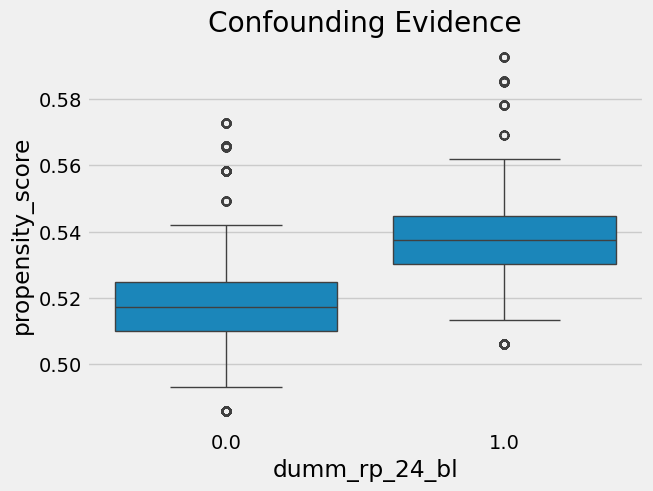

In [10]:
sns.boxplot(x='dumm_rp_24_bl', y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

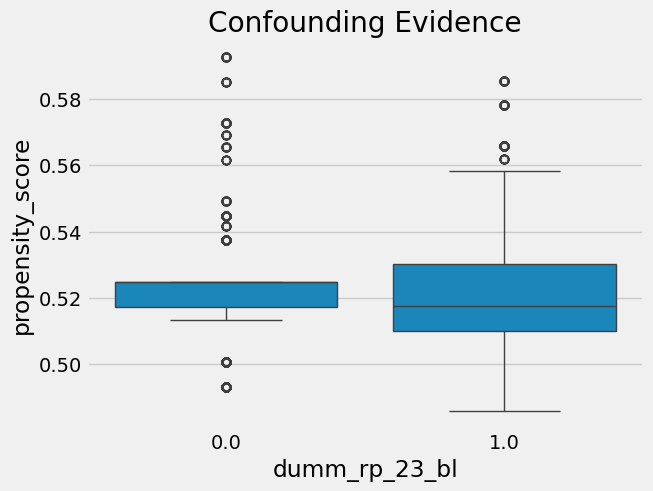

In [11]:
sns.boxplot(x='dumm_rp_23_bl', y="propensity_score", data=data_ps)
plt.title("Confounding Evidence");

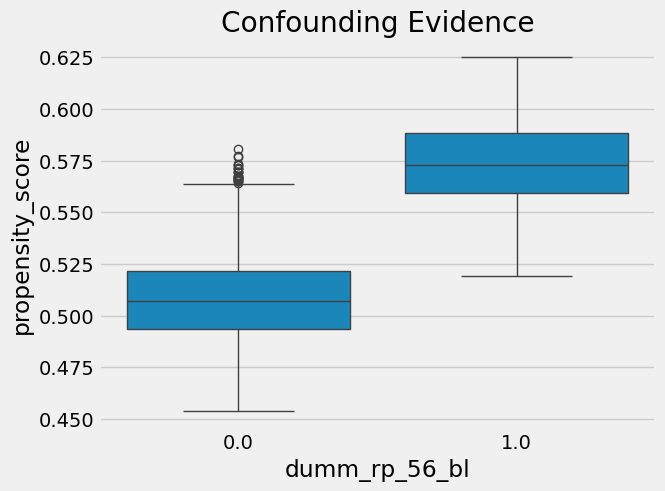

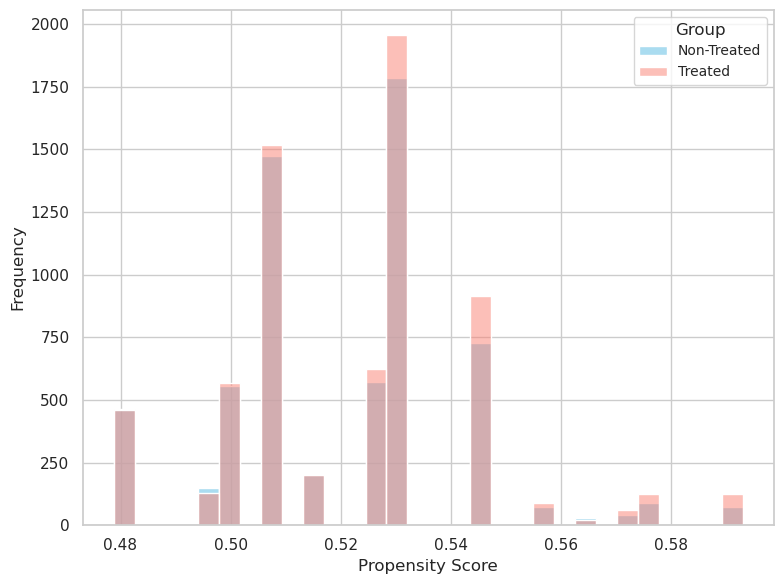

In [11]:
import seaborn as sns

sns.set(style="whitegrid") 
plt.figure(figsize=(8, 6))  
sns.histplot(data_ps.query("treatment==0")["propensity_score"], 
             bins=30, color="skyblue", alpha=0.7, label="Non-Treated")
sns.histplot(data_ps.query("treatment==1")["propensity_score"], 
             bins=30, color="salmon", alpha=0.5, label="Treated")


plt.xlabel("Propensity Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
#plt.title("Distribution of Propensity Scores by Treatment Status For Follo", fontsize=14)
plt.legend(title="Group", fontsize=10, title_fontsize=12, loc='upper right')
plt.tight_layout()

plt.savefig("positivity_check_1_colored.png", dpi=300)
plt.show()

In [14]:
weight = ((data_ps["treatment"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("treatment==1")["dumm_rp88__92C_fup"]*weight_t) / len(df_cleaned)
y0 = sum(data_ps.query("treatment==0")["dumm_rp88__92C_fup"]*weight_nt) / len(df_cleaned)

ate = np.mean(weight * data_ps["dumm_rp88__92C_fup"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 0.23607097249755019
Y0: 0.23836875940299576
ATE -0.0022977869054459973


In [13]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    df = df.sample(frac=1, replace=True)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000

ates = Parallel(n_jobs=4)(delayed(run_ps)(df_cleaned, categ, 'treatment', 'dumm_rp88__92C_fup')
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [14]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: -0.004450962233011711
95% C.I.: (-0.016932034726300643, 0.00790465248671163)


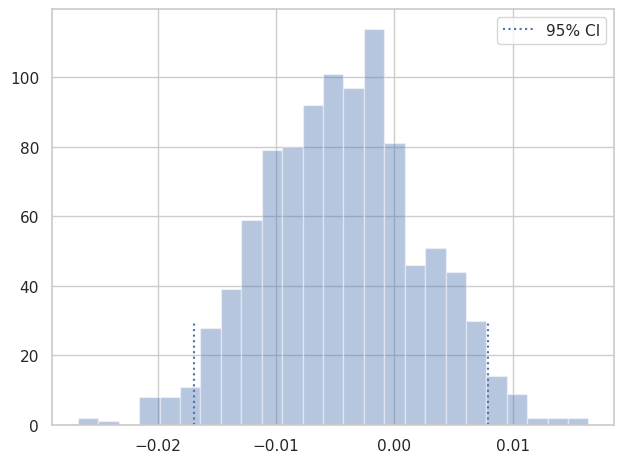

In [16]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
#plt.title("ATE Bootstrap Distribution For IPW estimate, credit card usage at first follow up")
plt.legend();

plt.tight_layout()

# Save as high-resolution figure
plt.savefig("bootstrap_colored1.png", dpi=300)
plt.show()

ATE: -0.002494168221907972
95% C.I.: (-0.015691640818484336, 0.011033536477691841)


## Second Follow up Survey 

for the analysis of treatment impact at the second follow up survey student is behind on payments, student comparison shops before making purchases and parent makes a list of all monthly expenses are included as covariances in line with the results in \autoref{tab:blandfup1diff2}, along with baseline credit card usage and student has bought on installments. 

In [6]:
categ = ['dumm_rp88__92C_fup', 'dumm_rp_56_bl', 'dumm_search_bl', 'dumm_rp_14p_bl', 'dumm_rp88__92D_bl']
df_cleaned = follow_up_2_df.dropna(subset=categ)
print(df_cleaned.shape)

(9345, 212)


In [7]:
from sklearn.linear_model import LogisticRegression

T = df_cleaned['treatment']
Y = df_cleaned['dumm_rp88__92C_fup']
X = df_cleaned[categ]

ps_model = LogisticRegression(C=1e6).fit(X, T)

data_ps = df_cleaned.assign(propensity_score=ps_model.predict_proba(X)[:, 1])

data_ps[["treatment", "dumm_rp88__92C_fup", "propensity_score"]].head()

,treatment,dumm_rp88__92C_fup,propensity_score
10,1.0,1.0,0.500432
13,0.0,0.0,0.508353
14,1.0,0.0,0.532282
16,1.0,1.0,0.475301
18,0.0,0.0,0.508353


In [ ]:
cm = CausalModel(
    Y=data_ps["dumm_rp88__92C_fup"].values, 
    D=data_ps["treatment"].values, 
    X=data_ps[["propensity_score"]].values
)

test = cm.est_via_matching(matches=1, bias_adj=True)
print(cm.estimates)

In [ ]:
test.summary_stats

In [10]:
weight_t = 1/data_ps.query("treatment==1")["propensity_score"]
weight_nt = 1/(1-data_ps.query("treatment==0")["propensity_score"])
print("Original Sample Size", df_cleaned.shape[0])
print("Treated Population Sample Size", sum(weight_t))
print("Untreated Population Sample Size", sum(weight_nt))

Original Sample Size 9345
Treated Population Sample Size 9344.577976558317
Untreated Population Sample Size 9345.34430523215


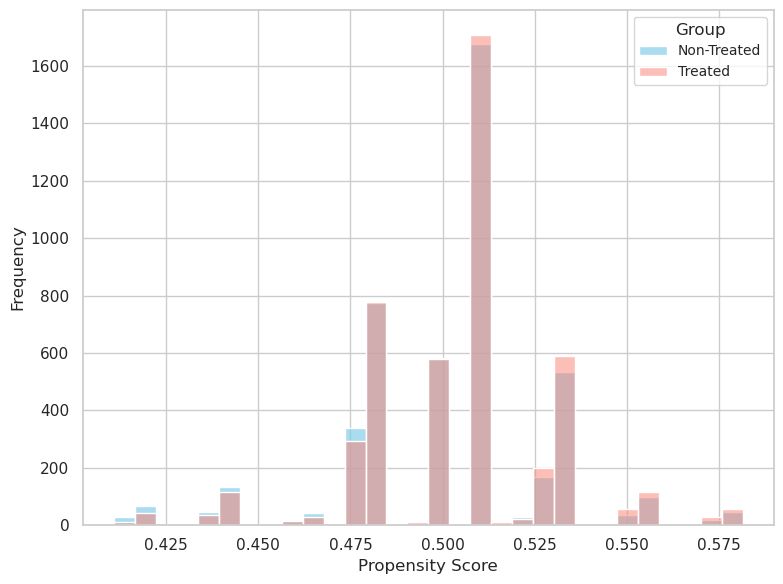

In [15]:
import seaborn as sns

sns.set(style="whitegrid") 
plt.figure(figsize=(8, 6))  
sns.histplot(data_ps.query("treatment==0")["propensity_score"], 
             bins=30, color="skyblue", alpha=0.7, label="Non-Treated")
sns.histplot(data_ps.query("treatment==1")["propensity_score"], 
             bins=30, color="salmon", alpha=0.5, label="Treated")


plt.xlabel("Propensity Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
#plt.title("Distribution of Propensity Scores by Treatment Status For Follo", fontsize=14)
plt.legend(title="Group", fontsize=10, title_fontsize=12, loc='upper right')
plt.tight_layout()

plt.savefig("positivity_check_AEJ_colored.png", dpi=300)
plt.show()

In [13]:
weight = ((data_ps["treatment"]-data_ps["propensity_score"]) /
          (data_ps["propensity_score"]*(1-data_ps["propensity_score"])))

y1 = sum(data_ps.query("treatment==1")["dumm_rp88__92C_fup"]*weight_t) / len(df_cleaned)
y0 = sum(data_ps.query("treatment==0")["vl_proficiencia_fup"]*weight_nt) / len(df_cleaned)

ate = np.mean(weight * data_ps["dumm_rp88__92C_fup"])

print("Y1:", y1)
print("Y0:", y0)
print("ATE", ate)

Y1: 63.534755026688686
Y0: 59.59668585796538
ATE 3.938069168723017


In [16]:
from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    df = df.sample(frac=1, replace=True)
    ps = LogisticRegression(C=1e6, max_iter=1000).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)
# run 1000 bootstrap samples
bootstrap_sample = 1000

ates = Parallel(n_jobs=4)(delayed(run_ps)(df_cleaned, categ, 'treatment', 'dumm_rp88__92C_fup')
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

In [17]:
print(f"ATE: {ates.mean()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")

ATE: -3.871625970814366e-06
95% C.I.: (-0.00018075426464003125, 0.0001491602836507187)


ATE: 3.9334666591971117
95% C.I.: (3.4397213672437075, 4.402411950319974)

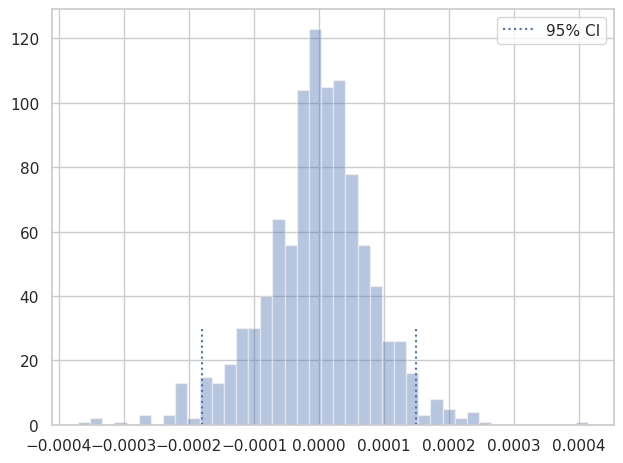

In [20]:
sns.distplot(ates, kde=False)
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
#plt.title("ATE Bootstrap Distribution For IPW estimate, credit card usage at first follow up")
plt.legend();

plt.tight_layout()

# Save as high-resolution figure
plt.savefig("bootstrap_colored.png", dpi=300)
plt.show()